In [1]:
import warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import os 
import sys
import math
import utm
import time

import json
import geopandas as gpd
import fiona
from geopy import distance

from numba import jit
import pickle

from pysheds.grid import Grid
from shapely.geometry import shape, mapping, Polygon
from pyproj import Proj

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from bokeh.plotting import ColumnDataSource, output_notebook
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Spectral3
from bokeh.layouts import gridplot

import matplotlib.pyplot as plt
import matplotlib.patches as mp

from get_station_data import get_daily_runoff
from radar_station_coords import radar_sites

output_notebook()
%matplotlib inline



Loading BokehJS ...

In [2]:
BASE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(''))))
DB_DIR = os.path.join(BASE_DIR, 'code/hydat_db')
PROJECT_DIR = os.path.abspath('')
RESULTS_DIR = os.path.join(PROJECT_DIR, 'data/AD_results')
FP_DIR = os.path.join(DB_DIR, 'na_dem_15s_grid')
GDIR_DIR = os.path.join(DB_DIR, 'na_dir_15s_grid')

In [3]:
results_folders = os.listdir(RESULTS_DIR)

results_dict = {}
# create a dictionary of results from all AD searches
for f in results_folders:
    folder_path = os.path.join(RESULTS_DIR, f)
    all_sites = [e.split('_')[0] for e in os.listdir(folder_path)]
    for site in all_sites:
        if site in results_dict.keys():
            old_results = results_dict[site]
            new_results = pd.read_csv(os.path.join(folder_path, site + '_results.csv'))
            results_dict[site] = pd.concat([old_results, new_results], sort=True)
        else:            
            results_dict[site] = pd.read_csv(os.path.join(folder_path, site + '_results.csv'))


def get_best_result(site):
    ad_df = pd.DataFrame(results_dict[site])
    ad_df.drop(labels='Unnamed: 0', inplace=True, axis=1)
    ad_df.sort_values('len_results', inplace=True, ascending=False)
    return ad_df.iloc[0, :]

In [4]:
def find_closest_radar_stn(row):
    """ 
    Input the dict of all station distances,
    Return the location code of the nearest radar station.
    """
    radar_station_distances = row['radar_stn_distance_dict']
    min_dist = min(radar_station_distances.items(), key=lambda x: x[1])
    return min_dist[0]


def find_closest_radar_stn_distance(row):
    """ 
    Input the dict of all station distances,
    Return the location code of the nearest radar station.
    """
    radar_station_distances = row['radar_stn_distance_dict']
    min_dist = min(radar_station_distances.items(), key=lambda x: x[1])
    return min_dist[1]


def calc_distance(wsc_row, station):
    wsc_stn_coords = (wsc_row['Latitude'], wsc_row['Longitude'])
    radar_coords = radar_sites[station]['lat_lon']
    return distance.distance(radar_coords, wsc_stn_coords).km

def calculate_radar_stn_distances(row):
    distance_dict = {}
    for site in radar_sites:
        distance_dict[site] = calc_distance(row, site)
    return distance_dict

def initialize_wsc_station_info_dataframe():
    # import master station list
    stations_df = pd.read_csv(DB_DIR + '/WSC_Stations_Master.csv')
    # filter for stations that have concurrent record with the historical radar record
    stations_df['RADAR_Overlap'] = stations_df['Year To'].astype(int) - 2007
    stations_filtered = stations_df[stations_df['RADAR_Overlap'] > 0]
    # filter for stations that are natural flow regimes
    stations_filtered = stations_filtered[stations_filtered['Regulation'] == 'N']
    stations_filtered.rename(columns={'Gross Drainage Area (km2)': 'DA'}, inplace=True)
    # filter for stations in Alberta and British Columbia
    stations_filtered = stations_filtered[(stations_filtered['Province'] == 'BC') | (stations_filtered['Province'] == 'AB')]
    
    # calculate distance to each radar station
    stations_filtered['radar_stn_distance_dict'] = stations_filtered.apply(lambda row: calculate_radar_stn_distances(row), axis=1)    
    stations_filtered['closest_radar_station'] = stations_filtered.apply(lambda row: find_closest_radar_stn(row), axis=1)
    stations_filtered['radar_distance_km'] = stations_filtered.apply(lambda row: find_closest_radar_stn_distance(row), axis=1)
    
    # radar range is a 240km radius from the station
    stations_filtered = stations_filtered[stations_filtered['radar_distance_km'] < 200]
    stn_df = stations_filtered[np.isfinite(stations_filtered['DA'].astype(float))]
    # filter for stations greater than 10 km^2 (too small for meaningful results)
    stn_df = stn_df[stn_df['DA'].astype(float) >= 10]
    # filter for stations smaller than 1000 km^2 (too large and complex)
    stn_df = stn_df[stn_df['DA'].astype(float) < 1000].sort_values('DA')
    df = stn_df[['Province', 'Station Number', 'Station Name', 'DA', 
                 'Elevation', 'Latitude', 'Longitude', 'RADAR_Overlap',
                'closest_radar_station', 'radar_stn_distance_dict', 'radar_distance_km']]
#     print('After filtering, there are {} candidate stations.'.format(len(stn_df)))
    df.reset_index(inplace=True)
    return df


## Load Flow Path Data
Source: [USGS hydrosheds project](https://hydrosheds.cr.usgs.gov/datadownload.php).

In [5]:
gdb_path = os.path.join(DB_DIR, 'WSC_Basins.gdb.zip')
all_layers = fiona.listlayers(gdb_path)
all_layer_names = [e.split('_')[1].split('_')[0] for e in all_layers]
filtered_layers = sorted(list(set(all_sites).intersection(all_layer_names)))

In [6]:
all_sites = list(results_dict.keys())

wsc_info = initialize_wsc_station_info_dataframe()


In [7]:
dem_save_path = os.path.join(PROJECT_DIR, 'data/dem_data')
all_dem_files = [e.split('.')[0] for e in os.listdir(dem_save_path)]

def get_basin_data(stn):
    # original WSC basin polygon is EPSG: 4269 (NAD83)
    # WGS 84 is EPSG: 4326
    basin_df = gpd.GeoDataFrame()
    layer_label = 'EC_' + stn + '_1'
    try:
        s = gpd.read_file(gdb_path, driver='FileGDB', layer=layer_label)
        basin_df = basin_df.append(s, ignore_index=True)
        return basin_df
    except ValueError as err:
        print(err)
        return []

def load_dem_data(stn):
#     grid = Grid.from_ascii(os.path.join(ascii_save_path, stn + '.asc'),
#                           data_name='dem')
    return grid

In [8]:
# For DEM plot
# Specify directional mapping
#         N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)
boundaries = ([0] + sorted(list(dirmap)))

In [9]:
def delineate_catchment_and_save_dem(stn):
    t0 = time.time()
    basin_data = get_basin_data(stn)
    if len(basin_data) == 0:
        return None
    stn_info = wsc_info[wsc_info['Station Number'] == stn]
    stn_da = stn_info['DA'].values[0]
    stn_el = stn_info['Elevation'].values[0]
    print('    {} ({} km2) el. {} m'.format(stn, stn_da, stn_el))
    x, y = stn_info['Longitude'].values[0], stn_info['Latitude'].values[0]
    
    basin_geom = basin_data.geometry
    basin_geom = basin_geom.to_crs(4326)
    basin_bounds = basin_geom.bounds
    basin_bbox = tuple((basin_bounds['minx'].values[0] - 0.007,
                basin_bounds['miny'].values[0] - 0.007,
                basin_bounds['maxx'].values[0] + 0.007,
                basin_bounds['maxy'].values[0] + 0.007))
    
    # For DEM plot
    # Specify directional mapping
    #         N    NE    E    SE    S    SW    W    NW
    dirmap = (64,  128,  1,   2,    4,   8,    16,  32)
    boundaries = ([0] + sorted(list(dirmap)))

    grid = Grid.from_raster(path=FP_DIR + '/na_dem_15s/na_dem_15s', 
                            data_name='dem', window=basin_bbox,
                            window_crs=Proj(4326))
    grid.read_raster(GDIR_DIR + '/na_dir_15s/na_dir_15s', 
                        data_name='dir', window=basin_bbox,
                window_crs=Proj(4326))
    
    grid.accumulation(data='dir', dirmap=dirmap, out_name='acc', apply_mask=False)

    x, y = grid.snap_to_mask(grid.acc > 20, [x, y], return_dist=False)
    # Delineate the catchment
    grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
                   recursionlimit=15000, xytype='label', nodata_out=0)

    grid.clip_to('catch')
    catch = grid.view('dem', nodata=np.nan)
    
    nns = catch.size - np.count_nonzero(np.isnan(catch))
    c = np.matrix(catch)
#     c = c.where(c == 0, np.nan, c)
    t1 = time.time()
    with open(dem_save_path + '/{}.p'.format(stn), 'wb') as fp:
        pickle.dump(c, fp, protocol=pickle.HIGHEST_PROTOCOL)
        print('    {}.p saved with {} points in {:.2f}s.'.format(stn, nns, t1-t0))
        
    return catch
    
    

In [10]:
# catch = delineate_catchment_and_save_dem(all_sites[:3])

In [13]:
all_pickles = os.listdir(dem_save_path)
print(sorted(all_pickles))
ddd = pickle.load( open(os.path.join(dem_save_path, all_pickles[0]), "rb" ) )
# print(ddd)

['05AA027.p', '05AA909.p', '05AB013.p', '05AB029.p', '05AB040.p', '05AC030.p', '05AD035.p', '05BG006.p', '05BH014.p', '05BJ004.p', '05BK001.p', '05BL013.p', '05BL014.p', '05BL019.p', '05BL023.p', '05BM014.p', '05BM018.p', '05CA002.p', '05CA004.p', '05CA011.p', '05CA012.p', '05CC013.p', '05CD007.p', '05CE010.p', '05CE018.p', '05CG004.p', '05CG006.p', '05DB002.p', '05DB005.p', '05FA014.p', '05FC007.p', '07EE009.p', '08GA072.p', '08GA075.p', '08GA077.p', '08GA079.p', '08HA003.p', '08HA070.p', '08HB086.p', '08HB089.p', '08JE004.p', '08KA001.p', '08KA009.p', '08KB006.p', '08KE024.p', '08LB024.p', '08LC040.p', '08LE027.p', '08LF094.p', '08LG016.p', '08LG048.p', '08MC045.p', '08MG001.p', '08MH006.p', '08MH029.p', '08MH076.p', '08MH141.p', '08MH147.p', '08MH155.p', '08NB014.p', '08ND012.p', '08NE039.p', '08NE077.p', '08NE087.p', '08NE110.p', '08NE114.p', '08NH005.p', '08NH130.p', '08NJ026.p', '08NJ061.p', '08NJ160.p', '08NJ168.p', '08NK018.p', '08NK022.p', '08NL050.p', '08NM142.p', '08NM173.p'

In [14]:
i = 1
sites = sorted(all_sites)
for stn in ['08HB048']:#sites[:1]:
    print('{}/{}: {}'.format(i, len(all_sites), stn))
    c = delineate_catchment_and_save_dem(stn)
    i += 1

1/125: 08HB048
    08HB048 (10.3 km2) el. 4.4293069839 m
    08HB048.p saved with 57 points in 6.03s.


In [34]:
def get_dem_data(stn, check_accum):
    print('{} loading...'.format(stn))

    t0 = time.time()
    basin_data = get_basin_data(stn)
    
    if len(basin_data) == 0:
        return None, False
    else:
        stn_info = wsc_info[wsc_info['Station Number'] == stn]
        stn_da = stn_info['DA'].values[0]
        stn_name = stn_info['Station Name'].values[0]
        stn_el = stn_info['Elevation'].values[0]
        x, y = stn_info['Longitude'].values[0], stn_info['Latitude'].values[0]

        basin_geom = basin_data.geometry
        basin_geom = basin_geom.to_crs(4326)
        basin_bounds = basin_geom.bounds
        basin_bbox = tuple((basin_bounds['minx'].values[0] - 0.001,
                    basin_bounds['miny'].values[0] - 0.001,
                    basin_bounds['maxx'].values[0] + 0.001,
                    basin_bounds['maxy'].values[0] + 0.001))

        # For DEM plot
        # Specify directional mapping
        #         N    NE    E    SE    S    SW    W    NW
        dirmap = (64,  128,  1,   2,    4,   8,    16,  32)
        boundaries = ([0] + sorted(list(dirmap)))

        grid = Grid.from_raster(path=FP_DIR + '/na_dem_15s/na_dem_15s', 
                                data_name='dem', window=basin_bbox,
                                window_crs=Proj(4326))
        grid.read_raster(GDIR_DIR + '/na_dir_15s/na_dir_15s', 
                            data_name='dir', window=basin_bbox,
                    window_crs=Proj(4326))

        grid.accumulation(data='dir', dirmap=dirmap, out_name='acc', apply_mask=False)

        if check_accum == True:
            x, y = grid.snap_to_mask(grid.acc > 20, [x, y], return_dist=False)

        # Delineate the catchment
        grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
                       recursionlimit=15000, xytype='label', nodata_out=0)

        grid.clip_to('catch', pad=(1,1,1,1))
        catch = grid.view('dem', nodata=np.nan)

        nns = catch.size - np.count_nonzero(np.isnan(catch))

        nns_ratio = nns / stn_da
        
        c = np.matrix(catch)

        t1 = time.time()
        if nns_ratio < 4:
            print('    #################')
            print('    Rechecking {}'.format(stn))
            return c, False

        if (nns_ratio < 4) | (nns_ratio > 9):
            print('{} is out to lunch, check it out: {:.2f}'.format(stn, nns))
        else:
            with open(dem_save_path + '/{}.p'.format(stn), 'wb') as fp:
                pickle.dump(c, fp, protocol=pickle.HIGHEST_PROTOCOL)
                print('    {}.p saved with {} points in {:.2f}s.'.format(stn, nns, t1-t0))

        print('{} {} ({} km2) el. {} m, pixels:da = {:.2f}'.format(stn, stn_name, stn_da, stn_el, nns/stn_da))
        return catch, True

In [35]:
for stn in ['08HB048']:#sites[27:]:
    catch, check = get_dem_data(stn, check_accum=False)
    if check == False:
        catch, check = get_dem_data(stn, check_accum=True)
    if check == False:
        print('')
        print('{} is no good')
        print('')

08HB048 loading...
    #################
    Rechecking 08HB048
08HB048 loading...
    08HB048.p saved with 52 points in 6.12s.
08HB048 CARNATION CREEK AT THE MOUTH (10.3 km2) el. 4.4293069839 m, pixels:da = 5.05


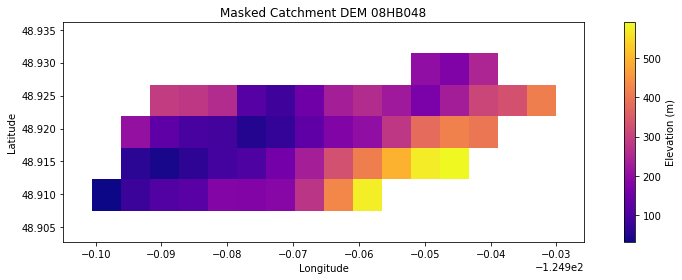

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.imshow(catch, extent=catch.extent, zorder=1, cmap='plasma')
plt.colorbar(label='Elevation (m)')
# ax.scatter(x, y, marker='x', c='r', zorder=2)
plt.title('Masked Catchment DEM 08HB048')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()

In [ ]:
bad_stns = '05BK001', '05AB013', '05HB013', '05BL022'